# Little Hope Creek :: Peak Flow Analysis

This workflow demonstrates an application of event detection to generate a distribution of peak discharges from [Little Hope Creek](https://waterdata.usgs.gov/nc/nwis/inventory/?site_no=02146470&agency_cd=USGS) in North Carolina.

In this notebook, one year of streamflow data for [Little Hope
Creek](https://waterdata.usgs.gov/nc/nwis/inventory/?site_no=02146470&agency_cd=USGS)
is retrieved from the USGS instantaneous value API and cached it in a sqlite3
database. Next, the retrieved observation data is cleaned and resampled then an
event detection algorithm is applied to the timeseries. This workflow applies
event detection using time series decomposition as found in the
[Hydrotools](https://github.com/NOAA-OWP/hydrotools) package. Subsequently, the
peak discharge for each event is paired. Lastly, two figures: a histogram of
peak discharges and a streamflow hydrograph depicting the start times of all
events are created. Below, we step through each part of the functionally
equivalent `little_hope.py` script and explain the process.


## Preparing the environment

This example can be run in one of three ways:

1. In a [Google Colab Notebook](https://colab.research.google.com/github/NOAA-OWP/hydrotools/blob/main/examples/little_hope/little_hope.ipynb.) (easiest)

2. On your local machine:
  0. The `Makefile` in the `examples/little_hope`(https://github.com/NOAA-OWP/hydrotools/blob/main/examples/little_hope/) directory will build the python environment and run the `little_hope.py` script or start a local jupyter notebook server. This notebook and the script are functionally equivalent. To and run, clone or [download a zipped version of the repo](https://github.com/NOAA-OWP/hydrotools/archive/refs/heads/main.zip). Navigate to `examples/little_hope` on your machine and run one of the `make` commands specified below.
  1. Running in a local Jupyter notebook
    - Run `make events`
   
  2. Running the standalone `little_hope.py` script.
    - Run `make run`
  


## 0. Install dependencies



In [ ]:
!pip install hydrotools.nwis_client hydrotools.events matplotlib

## 1. Import dependencies
Import the `nwis_client` tool to retrieve USGS streamflow measurements, `event_detection` to look for hydrological events in a time series of streamflow measurements, and `matplotlib` to plot the results.

In [1]:
# Import tools to retrieve data and detect events
from hydrotools.nwis_client.iv import IVDataService
from hydrotools.events.event_detection import decomposition as ev
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Retrieve data
Use the `nwis_client` tool to retrieve one year of streamflow measurements from Little Hope Creek.

In [2]:
# Retrieve streamflow observations for Little Hope Creek
observations = IVDataService().get(
    sites='02146470', 
    startDT='2019-10-01', 
    endDT='2020-09-30'
    )

# Look at raw data
observations.head()

,value_date,variable_name,usgs_site_code,measurement_unit,value,qualifiers,series
0,2019-09-30 23:00:00,streamflow,02146470,ft3/s,0.72,['A'],0
1,2019-09-30 23:05:00,streamflow,02146470,ft3/s,0.79,['A'],0
2,2019-09-30 23:10:00,streamflow,02146470,ft3/s,0.79,['A'],0
3,2019-09-30 23:15:00,streamflow,02146470,ft3/s,0.72,['A'],0
4,2019-09-30 23:20:00,streamflow,02146470,ft3/s,0.72,['A'],0


## 3. Preprocess streamflow measurements
Let's reduce the size of the data and make sure the data is consistent. This means dropping extra columns, checking for duplicate data, filling missing data, resampling the data to a consistent frequency, and indexing the data by datetime.

In [3]:
# Drop extra columns to be more efficient
observations = observations[['value_date', 'value']]

# Check for duplicate time series, keep first by default
observations = observations.drop_duplicates(subset=['value_date'])

# Resample to hourly, keep first measurement in each 1-hour bin
observations = observations.set_index('value_date')
observations = observations.resample('H').first().ffill()

# Look at preprocessed data
observations.head()

,value
value_date,
2019-09-30 23:00:00,0.72
2019-10-01 00:00:00,0.72
2019-10-01 01:00:00,0.72
2019-10-01 02:00:00,0.72
2019-10-01 03:00:00,0.79


## 4. Process streamflow record
Run event detection to generate a list of hydrological events with start and end times. This particular method of event detection is suitable for use on small streams dominated by rainfall-driven direct runoff events.

In [4]:
# Detect events
events = ev.list_events(
    observations['value'],
    halflife='6H', 
    window='7D',
    minimum_event_duration='6H',
    start_radius='6H'
)

# Look at events
events.head()

,start,end
0,2019-10-13 02:00:00,2019-10-15 00:00:00
1,2019-10-15 12:00:00,2019-10-17 21:00:00
2,2019-10-18 09:00:00,2019-10-23 13:00:00
3,2019-10-26 09:00:00,2019-10-28 10:00:00
4,2019-10-29 17:00:00,2019-11-02 17:00:00


## 5. Analyze events
Here we compare the `events` DataFrame to the original `observations` DataFrame and get the maximum for every period defined by `start` and `end` columns in `events.

In [5]:
# Compute peak discharge for each event
events['peak'] = events.apply(
    lambda e: observations['value'].loc[e.start:e.end].max(), 
    axis=1
    )

# Peaks have been added to each event
events.head()

,start,end,peak
0,2019-10-13 02:00:00,2019-10-15 00:00:00,30.000000
1,2019-10-15 12:00:00,2019-10-17 21:00:00,63.900002
2,2019-10-18 09:00:00,2019-10-23 13:00:00,217.000000
3,2019-10-26 09:00:00,2019-10-28 10:00:00,19.100000
4,2019-10-29 17:00:00,2019-11-02 17:00:00,153.000000


## 6. Visualize the results
Below we plot a histogram of peak flows for all events and the entire streamflow hydrograph for Little Hope Creek with points that indicate all the start time events detected.

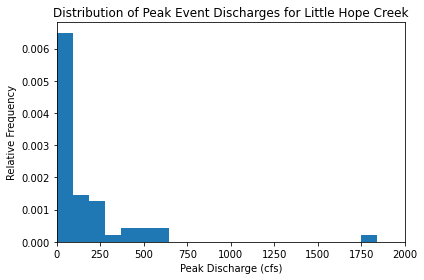

In [6]:
# Plot a histogram of peak discharge values
plt.hist(events['peak'], bins=20, density=True)
plt.xlim(0.0,2000.0)
plt.xlabel('Peak Discharge (cfs)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Peak Event Discharges for Little Hope Creek')
plt.tight_layout()
plt.show()

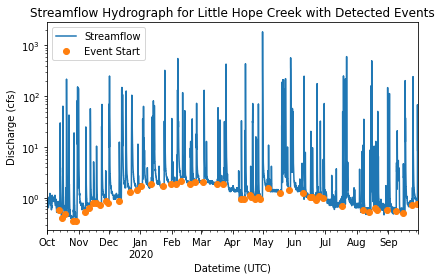

In [7]:
# Plot the hydrograph
observations.plot(logy=True, legend=False)
observations.loc[events['start'], 'value'].plot(
    ax=plt.gca(), style='o'
)
plt.xlabel('Datetime (UTC)')
plt.ylabel('Discharge (cfs)')
plt.legend(['Streamflow','Event Start'])
plt.title('Streamflow Hydrograph for Little Hope Creek with Detected Events')
plt.tight_layout()
plt.show()